# Monte Carlo Localization + 膨張リセット

千葉工業大学 上田 隆一

(c) 2017 Ryuichi Ueda

This software is released under the MIT License, see LICENSE.

## はじめに

このコードは、kiddnapped robot problemが起こったときのMCL+膨張リセットの挙動を示すものです。

## コード

しばらく1.monte_calro_localization.ipynb と同じです。

In [1]:
%matplotlib inline
import numpy as np
from copy import copy
import math, random
import matplotlib.pyplot as plt                   #   for plotting data
from matplotlib.patches import Ellipse      #  for drawing

class Gaussian2D:
    # 共分散行列、中心の座標を属性に持つ
    def __init__(self,sigma_x = 1.0, sigma_y = 1.0, cov_xy = 0.0,mu_x = 0.0, mu_y = 0.0):
        self.cov = np.array([[sigma_x**2,cov_xy],[cov_xy,sigma_y**2]])
        self.mean = np.array([mu_x,mu_y]).T
        
    # ガウス分布の移動
    def shift(self,delta,angle):
        ca = math.cos(angle)
        sa = math.sin(angle)
        rot = np.array([[ca,sa],[-sa,ca]])
        
        self.cov = rot.dot(self.cov).dot(rot.T)
        self.mean = self.mean + delta
        
    # 密度の算出
    def value(self, pos):
        delta = pos - self.mean
        numerator = math.exp(-0.5 * (delta.T).dot(np.linalg.inv(self.cov)).dot(delta))
        denominator = 2 * math.pi * math.sqrt(np.linalg.det(self.cov))
        return numerator / denominator

class Landmarks:
    def __init__(self,array):
        self.positions = array
    
    def draw(self):
        xs = [ e[0] for e in self.positions]
        ys = [ e[1] for e in self.positions]
        plt.scatter(xs,ys,s=300,marker="*",label="landmarks",color="orange")
        

class Observation:
    def __init__(self,robot_pos, landmark,lid):
        # センサの有効範囲の設定
        self.sensor_max_range = 1.0
        self.sensor_min_range = 0.1
        self.sensor_max_angle = math.pi / 2
        self.sensor_min_angle = - math.pi /2 
        
        # ランドマークのIDを保存しておく属性。ランドマークがセンサの有効範囲にないとNoneのまま
        self.lid = None
        
        # 真の位置の情報をセットする。ロボットの真の姿勢はシミュレーション用でロボットは知らないという前提。
        # 真のランドマークの位置は、ロボットは知っているのでこのインスタンスの属性として保存します。
        rx,ry,rt = robot_pos
        self.true_lx,self.true_ly = landmark
        
        # ロボットからランドマークまでの距離の真値を算出
        distance = math.sqrt((rx-self.true_lx)**2 + (ry-self.true_ly)**2)
        if distance > self.sensor_max_range or distance < self.sensor_min_range:
            return
        
        # ロボットからランドマークがどの方向に見えるか真値を算出
        direction = math.atan2(self.true_ly-ry, self.true_lx-rx) - rt
        if direction > math.pi:    direction -= 2*math.pi
        if direction < -math.pi:   direction += 2*math.pi     
        if direction > self.sensor_max_angle or direction < self.sensor_min_angle:
            return
        
        # 真値に混入する雑音の大きさ（標準偏差）を設定
        sigma_distance = distance * 0.1           # 距離に対して10%の標準偏差
        sigma_direction = math.pi * 3 / 180    # ランドマークの方向に対して3degの標準偏差
        
        # 雑音を混ぜてセンサの値とする
        self.distance = random.gauss(distance, sigma_distance)   
        self.direction = random.gauss(direction, sigma_direction)
     
        # ロボット座標系での共分散行列を作っておく。あとで尤度を計算するときに使用
        # x方向が奥行きで、sigma_distanceを標準偏差に設定。y方向がロボットから見て横方向の誤差で、距離*sin(3[deg])となる。
        self.error_ellipse = Gaussian2D(sigma_x = sigma_distance, sigma_y = self.distance * math.sin(sigma_direction) , cov_xy = 0.0)

        self.lid = lid
        
    # 尤度の計算（遅い実装です。）
    # パーティクルの姿勢とランドマークの計測値からランドマークの位置を推定し、その位置に誤差楕円を置き、
    # ランドマークの真の位置が誤差楕円からどれだけ外れているかを確率密度関数の密度として返します。
    # この計算はもっと簡略化できますが、描画の関係でこういう手順を踏んでいます。
    # 簡略な方法: パーティクルの姿勢とランドマークの真の位置から、想定されるランドマークの距離・方向を算出し、
    # 実際の距離・方向とそれぞれ比較する方法。距離の誤差の傾向、方向の誤差の傾向をそれぞれ1次元のガウス分布で表現し、
    # それぞれを独立して計算して尤度を算出し、掛け算する。
    def likelihood(self,particle_pos): 
        # パーティクルの姿勢と、このインスタンスに保存されているセンサの値から、ランドマークの位置を求める
        rx, ry, rt = particle_pos
        proposed_lx = rx + self.distance * math.cos(rt + self.direction)
        proposed_ly = ry + self.distance * math.sin(rt + self.direction)
                
        # このインスタンスに保存されている共分散行列を、計算されたランドマークの位置に移し、パーティクルの向きに合わせて共分散行列を回転
        e = copy(self.error_ellipse)
        e.shift(np.array([proposed_lx, proposed_ly]).T, rt + self.direction)

        # そのままガウス分布の計算式から密度（尤度）を返します。
        return e.value(np.array([self.true_lx,self.true_ly]).T)
        
    # 描画用
    def ellipse(self,robot_pos):
        rx, ry, rt = robot_pos[0], robot_pos[1], robot_pos[2]
        proposed_lx = rx + self.distance * math.cos(rt + self.direction)
        proposed_ly = ry + self.distance * math.sin(rt + self.direction)
        
        e = copy(self.error_ellipse)
        e.shift(np.array([proposed_lx, proposed_ly]).T, rt + self.direction)
        
        # 固有ベクトルを二つ求めて、それぞれの大きさを求めて楕円を作り、幅を計算した方の固有ベクトルの向きに楕円を回転すると誤差楕円になります。
        eigen = np.linalg.eig(e.cov)
        
        v1 = eigen[0][0] * eigen[1][0]
        v2 = eigen[0][1] * eigen[1][1]
        v1_direction = math.atan2(v1[1],v1[0])
        
        elli = Ellipse([proposed_lx, proposed_ly],width=math.sqrt(np.linalg.norm(v1)),height=math.sqrt(np.linalg.norm(v2)),angle=v1_direction/3.14*180)
        elli.set_alpha(0.2)
        
        return elli
    
    # 描画用
    def draw(self,sp,robot_pos):
        sp.add_artist(self.ellipse(robot_pos)) 

actual_landmarks = Landmarks(np.array([[-0.5,0.0],[0.5,0.0],[0.0,0.5]]))

# パーティクルのクラス。単なる構造体
class Particle:
    def __init__(self,x,y,t,w):
        self.pos = np.array([x,y,t])
        self.w = w

# パーティクルフィルタのクラス
class ParticleFilter:
    # この実装ではコンストラクタはパーティクルの個数だけを引数にとる
    def __init__(self,num):
        # 空のパーティクルのリストを作って一つずつ追加していく（実装がベタ）
        self.particles = []
        for i in range(num):
            self.particles.append(Particle(0.0,0.0,0.0,1.0/num))    # パーティクルは重みを持つ。全パーティクルの重みの合計は1。1つのパーティクルの重みは1/個数
            
    # ロボットが動いたときにパーティクルを動かすためのメソッド
    # 引数の「motion」はメソッドで、ロボットの移動を再現するためのもの。
    # ロボットは自身がどのように動作するとどう姿勢が変化するかを知っており、このメソッドがその知識となる。
    def moveParticles(self,fw,rot,motion):
        w_sum = sum([e.w for e in self.particles])
        
        print(w_sum)
        if w_sum > 1e-10:
            self.resampling()       # リサンプリング
        else:
            print("reset")
            self.reset()                 # リセット
        
        # パーティクルごとに移動した後の姿勢を計算し、姿勢を更新する。
        for p in self.particles:
            after = motion(p.pos,fw,rot) 
            p.pos = after
            
    # リサンプリングのためのメソッド。
    # リサンプリングは、重みがごく少数のパーティクルに偏ることを防ぐための措置で、近似していない理論上の数式では出現しない。
    def resampling(self):
        num = len(self.particles)                # numはパーティクルの個数
        ws = [e.w for e in self.particles]    # 重みのリストを作る
        
        ps = random.choices(self.particles, weights=ws, k=num)    # パーティクルのリストから、weightsのリストの重みに比例した確率で、num個選ぶ
        self.particles = [Particle(*e.pos,1.0/num) for e in ps]          # 選んだリストからパーティクルを取り出し、パーティクルの姿勢から重み1/numの新しいパーティクルを作成

    def reset(self): #x,y,thetaの順で標準偏差を求めて位置をランダムに更新、膨張
        std_x = np.std([e.pos[0] for e in self.particles])
        std_y = np.std([e.pos[1] for e in self.particles])
        
        std_t1 = np.std([e.pos[2] for e in self.particles]) # この標準偏差は180度側と-180度側にパーティクルがあるとおかしな値になる
        # 180度シフトした角度でも標準偏差を求める
        shift_theta = [ e.pos[2] - math.pi if e.pos[2] > math.pi else e.pos[2] + math.pi for e in self.particles]
        std_t2 = np.std(shift_theta)
        # 小さい方を採用
        std_t = std_t1 if std_t1 < std_t2 else std_t2
        
        m, mt = 3, 10
        for p in self.particles:
            p.pos[0] = random.uniform(max([-1.0,p.pos[0]-m*std_x]),min([p.pos[0]+m*std_x,1.0]))
            p.pos[1] = random.uniform(max([-0.5,p.pos[1]-m*std_y]),min([p.pos[1]+m*std_y,1.5]))
            p.pos[2] += random.uniform(-mt*std_t,mt*std_t)
    
        num = len(self.particles) 
        for p in self.particles:
            p.w = 1.0/num
            
    # 描画用
    def draw(self,c="blue",lbl="particles"):
        xs = [p.pos[0] for p in self.particles]
        ys = [p.pos[1] for p in self.particles]
        vxs = [math.cos(p.pos[2]) for p in self.particles]
        vys = [math.sin(p.pos[2]) for p in self.particles]
        plt.quiver(xs,ys,vxs,vys,color=c,label=lbl,alpha=0.7)
        

以下は変更なし

In [2]:
class Robot:
    def __init__(self,x,y,rad):
        random.seed()
        
        # actual_poses: ロボットの姿勢の真値を1ステップごとに記録したもの
        # （ロボットのクラス内にいるけどロボットはこの情報を使えない）
        self.actual_poses = [np.array([x,y,rad])]
        
        # パーティクルフィルタの準備（パーティクル数30個）
        self.pf = ParticleFilter(300)
    
    #　ロボットの動作をシミュレートするメソッド。シミュレーションだけでなく、ロボットがパーティクルを移動するときにも用いる。
    # つまり実機に実装する場合もこのメソッドが必要となる。雑音の度合いは事前に計測するか、
    # ざっくり決めてフィルタのロバスト性に頼る。
    def motion(self, pos, fw, rot):
        # fwだけ前進してその後rotだけ回転。雑音を混入させる
        actual_fw = random.gauss(fw,fw/10)    #進む距離に対して標準偏差10%の雑音を混入
        dir_error = random.gauss(0.0, math.pi / 180.0 * 3.0) # 前進方向がヨレる雑音を標準偏差3[deg]で混入
        
        px, py, pt = pos
        # 移動後の位置を算出
        x = px + actual_fw * math.cos(pt + dir_error)
        y = py + actual_fw * math.sin(pt + dir_error)
        # 雑音込みの回転各を算出。rotに対して標準偏差10%の雑音を混ぜる
        actual_rot = random.gauss(rot,rot/10)
        t = pt + dir_error + actual_rot      # さらにヨレの分の角度を足す
        
        return np.array([x,y,t])
    
    # ロボットが動くときに呼び出すメソッド。ロボットの位置の更新とパーティクルの位置の更新
    def move(self,fw,rot):
        self.actual_poses.append(self.motion(self.actual_poses[-1],fw,rot))
        self.pf.moveParticles(fw,rot,self.motion)
        
    # ロボットがランドマーク観測するときに呼び出すメソッド
    def observation(self,landmarks):
        obss = []
        for i,landmark in enumerate(landmarks.positions):            # 3つあるランドマークを1つずつ観測
            obss.append(Observation(self.actual_poses[-1],landmark,i))
            obss = list(filter(lambda e : e.lid != None, obss))            # 観測データのないものを除去
            
        # 重みに尤度をかける
        for obs in obss:
            for p in self.pf.particles:
                p.w *= obs.likelihood(p.pos)
        
        # 描画用に観測のリストを返す
        return obss
        
    # 描画用
    def draw(self,sp,observations):
        for obs in observations:
            for p in self.pf.particles:
                obs.draw(sp,p.pos)
        
        self.pf.draw()
        
        xs = [e[0] for e in self.actual_poses]
        ys = [e[1] for e in self.actual_poses]
        vxs = [math.cos(e[2]) for e in self.actual_poses]
        vys = [math.sin(e[2]) for e in self.actual_poses]
        plt.quiver(xs,ys,vxs,vys,color="red",label="actual robot motion")

def draw(i,observations):
    fig = plt.figure(i,figsize=(8, 8))
    sp = fig.add_subplot(111, aspect='equal')
    sp.set_xlim(-1.0,1.0)
    sp.set_ylim(-0.5,1.5)

    robot.draw(sp,observations)
    
    actual_landmarks.draw()

    plt.legend()

## シミュレーションの実行

途中でロボットを別の場所にワープさせます。

図の説明: 

* 赤の矢印: 真の姿勢
* 星: ランドマークの位置
* 青の矢印: パーティクルの姿勢
* 楕円: ランドマークの観測値と各パーティクルの姿勢からランドマークの位置を計算したものと、その位置の曖昧さを表す共分散行列

2803.159807222842
67.13357552069402
284.30120059093423
0.9999999999999961
22.90190122360291
21.196236848873664
8.712548367558966e-84
reset
3.946512110666631e-107
reset
3.09888615688718e-07
6.707098253665708e-06
0.00041367177712373657
2.392634925001888
0.010481910153012733
0.4501580213559298
0.16647136550863542
0.9999999999999961
0.9999999999999961
11.419154238995015


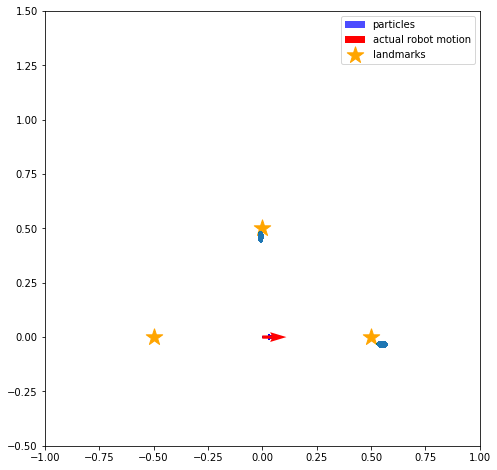

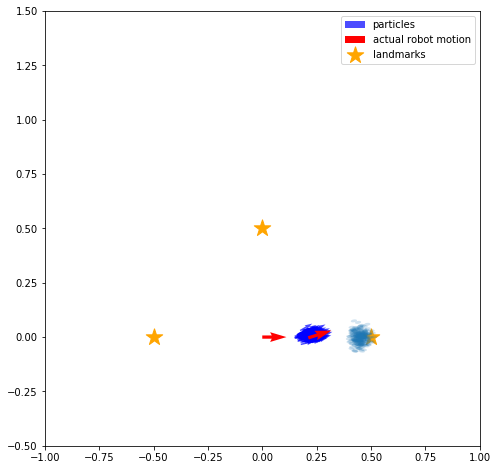

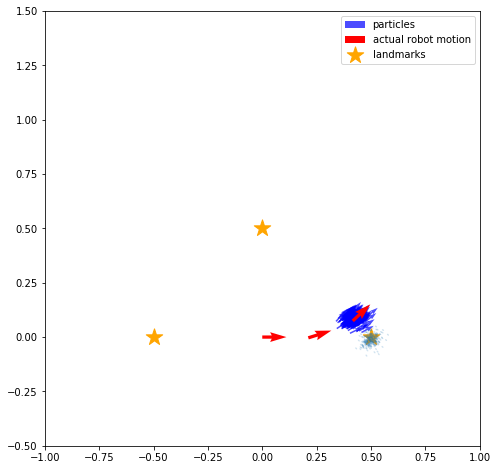

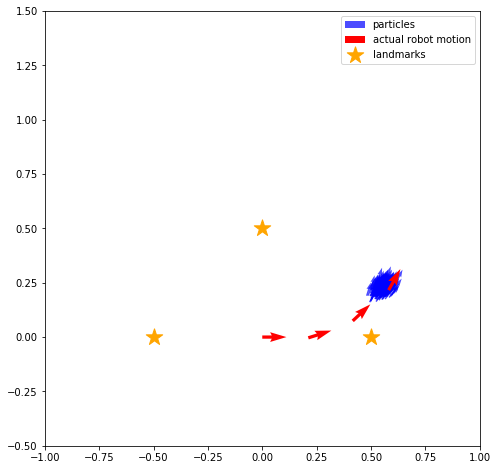

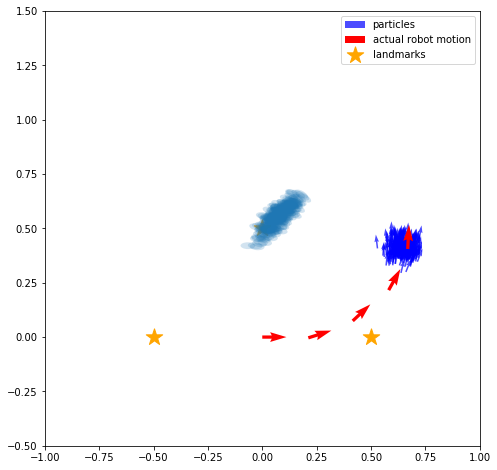

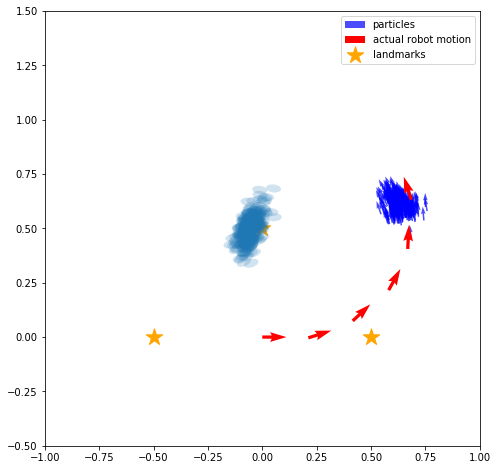

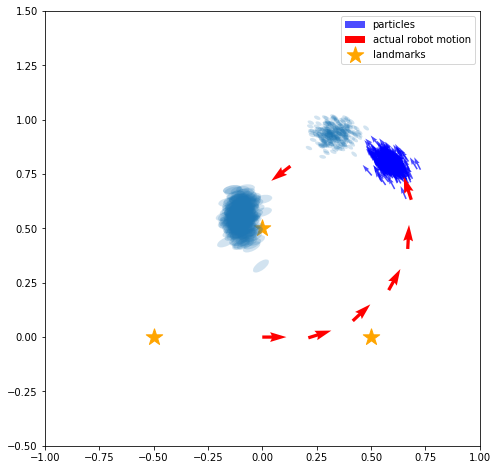

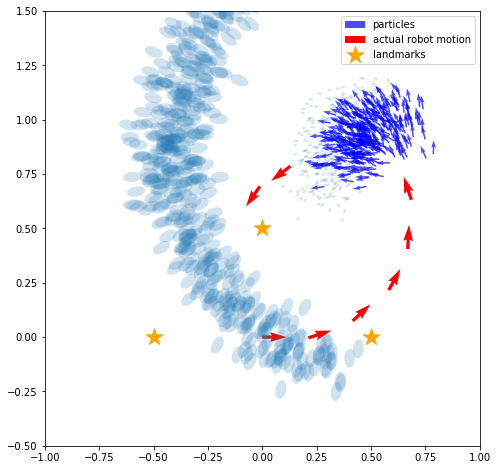

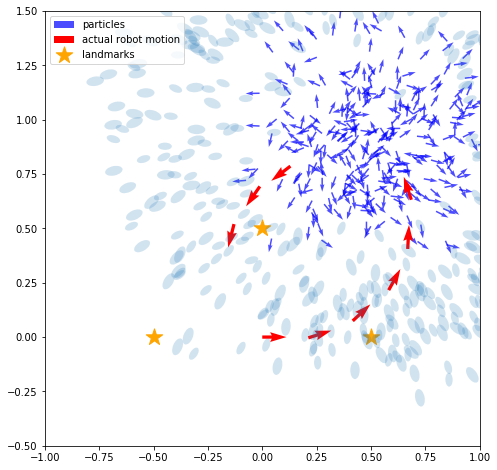

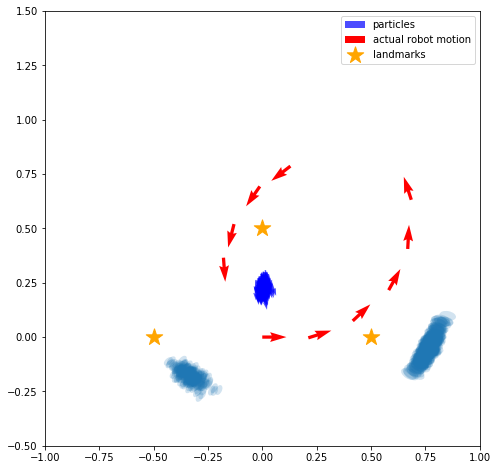

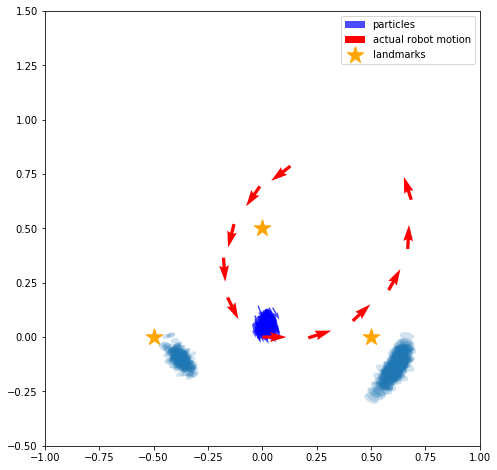

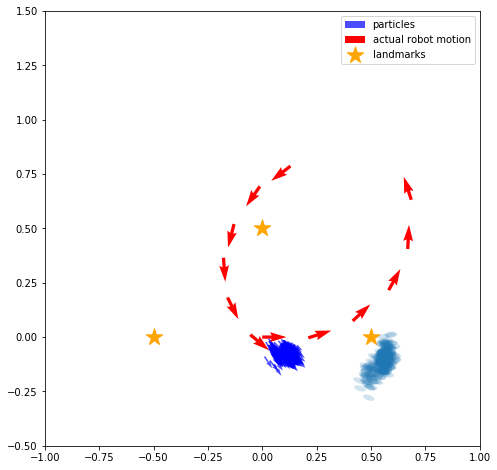

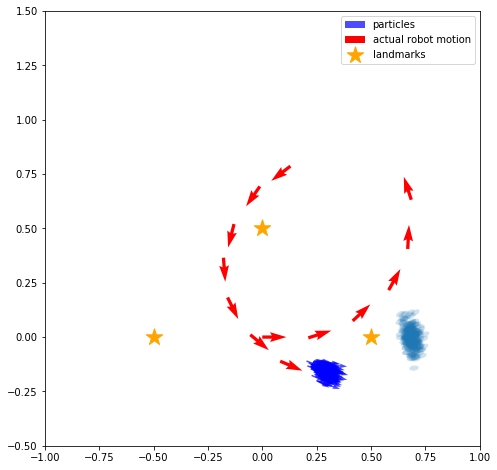

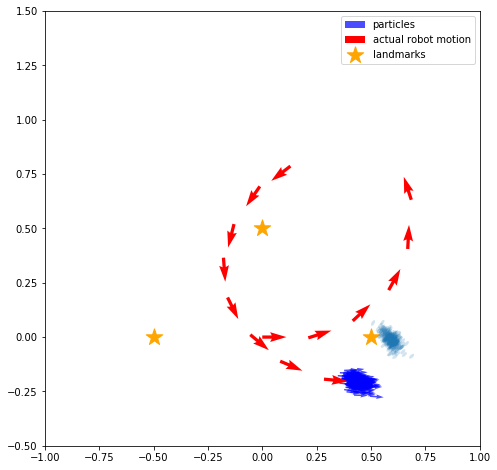

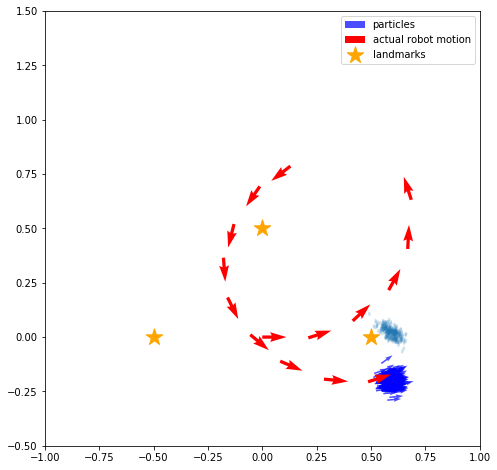

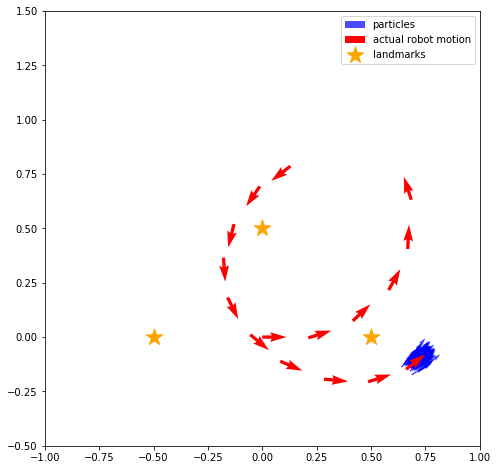

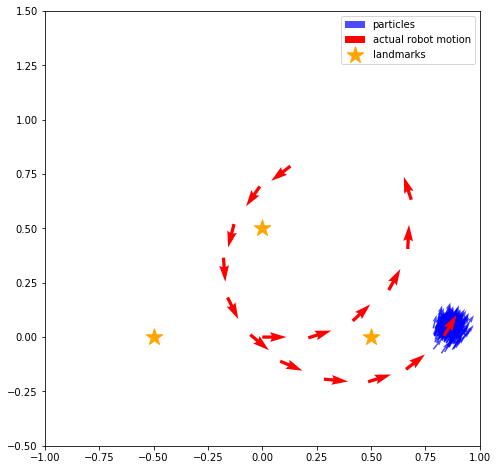

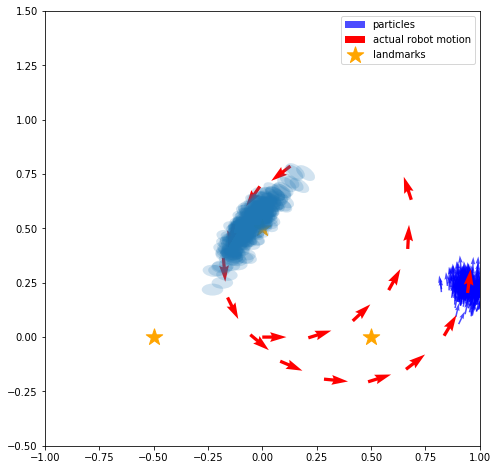

In [3]:
robot = Robot(0,0,0)      # ロボットを原点に

# 観測、描画、移動の繰り返し
for i in range(0,18):
    obss = robot.observation(actual_landmarks)
    draw(i,obss)
    robot.move(0.2,math.pi / 180.0 * 20)
    
    if i == 5:
        robot.actual_poses[-1][0] -= 0.5
        robot.actual_poses[-1][2] += math.pi/2
        